# Test assumption of exponentiality

It has been established that storm event arrivals could be assumed as a Poisson arrivals. In this case, the underlying distribution for time between storm arrivals ($t_a$) follows exponential distribution with parameteric form:
$$f_{T_a}(t_a) = \omega e^{-\omega t_a}$$
$\omega$ is average storm arrival rate \[$T^{-1}$] and scale parameter of the exponential distribution. Poisson process assumption holds given the independence of the rainstorms. Therefore, the condition
$$\omega m_{t_r} \ll 1$$
should satisfy. In here, $1/\omega$ is mean time between storm arrivals, and $m_{t_r}$ is the mean storm duration. 

The time between storms ($t_b$) should also follow an exponential distribution
$$f_{T_b}(t_b) = \beta e^{-\beta t_b}$$
where $1/\beta$ is mean time between storms. However, Restrepo-Posada and Eagleson \[[1](https://doi.org/10.1016/0022-1694(82)90136-6)] show that the exponential distribution does not fit well for the raw rainfall time-series. They suggest an approach to define **independent** set of storm events. They redefine storm events by clustering the multiple continuous rainfall pulses seperated in time with less than **minimum time between storms** $t_{b_{min}}$. They increase the $t_{b_{min}}$ values until $f_{T_b}(t_b)$ is sufficiently exponential. 

References:
\[1] Restrepo-Posada, P. J., & Eagleson, P. S. (1982). Identification of independent rainstorms. Journal of Hydrology, 55(1–4), 303–319. https://doi.org/10.1016/0022-1694(82)90136-6

## Test the assumption on hourly rain gauge and GPM satellite-based half-hourly, hourly, and daily rainfall

## Preprocess ASOS 
Info on ASOS: "The Automated Surface Observing System (ASOS) is considered to be the flagship automated observing network. Located at airports, the ASOS stations provide essential observations for the National Weather Service (NWS), the Federal Aviation Administration (FAA), and the Department of Defense (DOD). The primary function of the ASOS stations are to take minute-by-minute observations and generate basic weather reports \[[1](https://www.weather.gov/media/asos/aum-toc.pdf)].
Observations from the ASOS network are nationally monitored for quality 24 hours per day. Depending on the trouble, maintenance can be performed on the same day."([reference](https://mesonet.agron.iastate.edu/ASOS/))


## Preprocess GPM into hourly and daily and ASOS to daily

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# rc('text', usetex=False)
rc('font', family='default')
prod_list = dict({'ASOS':
                    {
                        'org_scale':'H',
                        'unit':'mm/hr',
                        'tscales':['H', 'D'],
                        'scale_f':24.5,
                        'dt_col':'valid',
                        'p_col':'precip_in',
                        'p_thres':0,
                        'fn': '/mnt/d/ubuntu/projects/gatechProjects/StochSM/data/gages/asos_test.csv'
                    },
                'GPM':
                    {
                        'org_scale':'HH',
                        'unit':'mm/hr',
                        'tscales':['30min', 'H', 'D'],
                        'scale_f': 1,
                        'dt_col':'dt',
                        'p_col':'precip',
                        'p_thres':0.5,
                        'fn': '/mnt/d/ubuntu/projects/gatechProjects/StochSM/data/GPM/csv_half_hourly/gpm_turkey.csv'
                    }
                }) 
# ASOS: Rain gauge-based precip data from Automated Surface Observing System --- GPM: Global Precipitation Mission
# HH: Half-hourly (GPM), H: Hourly (ASOS and GPM), D: Daily (ASOS & GPM)


In [2]:
_data = dict()
for key in prod_list:
    prod = prod_list[key]
    dt_col = prod['dt_col']
    p_col = prod['p_col']
    _data[key] = pd.read_csv(prod['fn'])
    _data[key]['timestamps'] = pd.to_datetime(_data[key][dt_col])
    idx = (_data[key][p_col] < prod['p_thres'])
    _data[key].loc[idx, p_col] = 0
    _data[key]['rain'] = _data[key][p_col] * prod['scale_f']
p_data = dict()
for key in prod_list:
    prod = prod_list[key]
    dt_col = prod['dt_col']
    p_col = prod['p_col']
    p_data[key] = dict()
    for tscale in prod['tscales']:
        x = _data[key].set_index('timestamps')
        if (key == 'GPM') & (tscale =='D'):
            p_data[key][tscale] = x['rain'].resample(tscale).sum()/2
        elif (key == 'GPM') & (tscale =='H'):
            p_data[key][tscale] = x['rain'].resample(tscale).sum()/2
        elif (key == 'ASOS') & (tscale =='H'):
            p_data[key][tscale] = x['rain'].resample(tscale).mean()
        elif (key == 'ASOS') & (tscale =='D'):
            # print('test' + key + tscale)
            p_data[key][tscale] = x['rain'].resample(tscale).sum()
        else:
            print('test1' + key + tscale)
            p_data[key][tscale] = x['rain']
        p_data[key][tscale] = p_data[key][tscale].reset_index()

test1GPM30min


In [3]:
from functions.event_detector import storm_def
import datetime

mit_list = [x for x in range(6,6*24, 6)]

p_events = dict()
for prod in ['GPM','ASOS']:
    _prod = prod_list[prod]
    dt_col = _prod['dt_col']
    p_col = _prod['p_col']
    p_events[prod] = dict()    
    for tscale in ['H']:
        data = p_data[prod][tscale]
        mit_dry = []
        # events = dict()
        # dry_periods = dict()
        # storm_arrivals = dict()
        # p_events[prod][tscale] = dict()
        for mit in mit_list:
            events = storm_def(data, mit)
            dry_periods = [(events['start'][i+1] - events['end'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
            storm_arrivals = [(events['start'][i+1] - events['start'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
            mit_dry.append((mit, np.std(dry_periods)/ np.mean(dry_periods),np.std(storm_arrivals)/ np.mean(storm_arrivals), 
            np.mean(dry_periods), np.mean(storm_arrivals)))
        p_events[prod][tscale] = np.array(mit_dry)

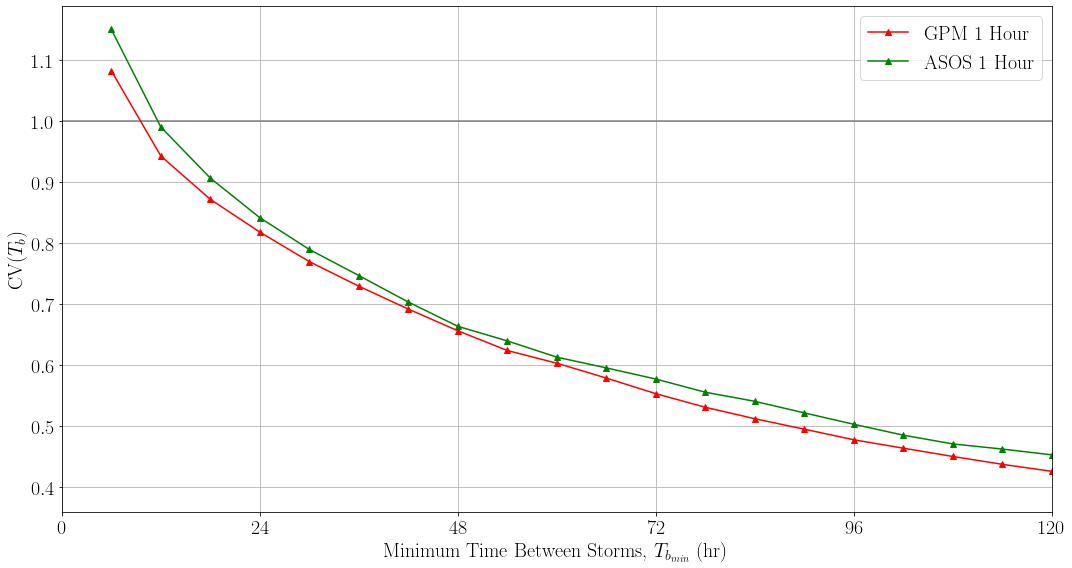

In [36]:

import scipy.stats as ss
fig,ax = plt.subplots(figsize=(15, 8))

# ax.plot(p_events['GPM']['30min'][:,0], p_events['GPM']['30min'][:,1], marker='o', label='GPM 30 min')
# ax.plot(p_events['GPM']['30min'][mit][:,0], p_events['GPM']['30min'][mit][:,2], marker='o')

ax.plot(p_events['GPM']['H'][:,0], p_events['GPM']['H'][:,1], marker='^', color='red', label='GPM 1 Hour')
ax.plot(p_events['ASOS']['H'][:,0], p_events['ASOS']['H'][:,1], marker='^', color='g', label='ASOS 1 Hour')
# ax.plot(p_events['GPM']['H'][mit][:,0], p_events['GPM']['H'][mit][:,2], marker='^')

# ax.plot(p_events['GPM']['D'][:,0], p_events['GPM']['D'][:,1], marker='v', label='GPM 1 Day')
# ax.plot(p_events['ASOS']['D'][:,0], p_events['ASOS']['D'][:,1], marker='^', label='ASOS 1 Day')

ax.hlines(1,xmin=0,xmax=120, color='gray')
# n, bins, patches = ax.hist(data, bins=bins, density=True, histtype='step', cumulative=-1)
ax.set_xlabel(r'Minimum Time Between Storms, $T_{b_{min}}$ (hr)', fontsize=20)
ax.set_ylabel(r'CV($T_b$)', fontsize=20)
ax.tick_params(labelsize = 20)
ax.grid('major')
ax.set_xticks(np.arange(0,120+24, 24))
ax.set_xticklabels([str(x) for x in np.arange(0,120+24, 24)])

ax.set_xlim([0, 120])
# ax.set_ylim([-0.1, 1.3])
# ax.text(0.5, 0.9,r'$f_{T_b}(t_b) =' + '{:.1f}'.format(scale)+'e^{-' + '{:.1f}'.format(scale)+ 't_b} $',transform=ax.transAxes, fontsize=28)
fig.tight_layout()
ax.legend(fontsize=20)
# fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/forcings/gpm_mit_tscales.jpg',dpi=300)


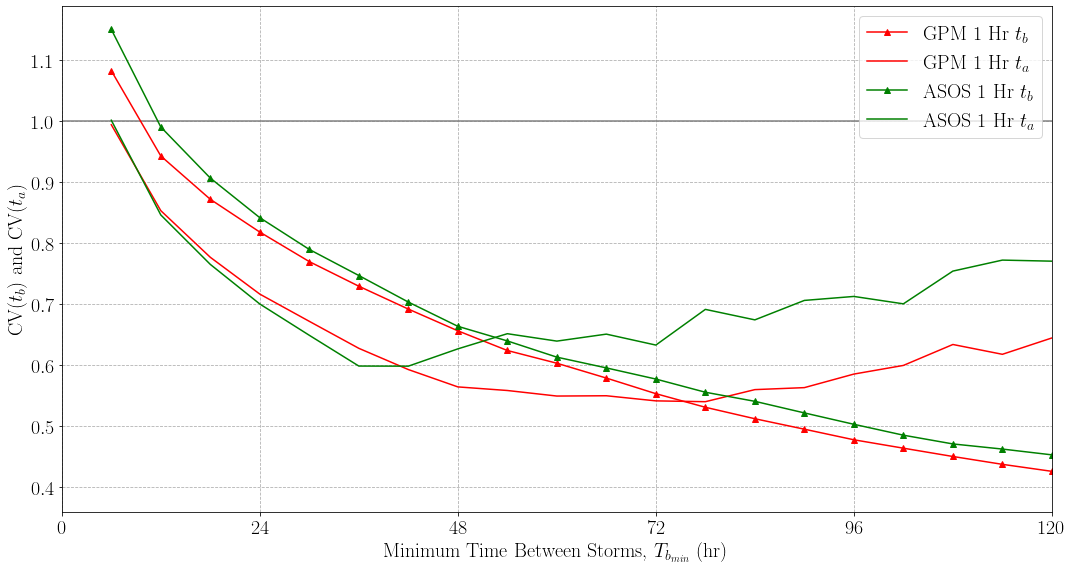

In [37]:

import scipy.stats as ss
fig,ax = plt.subplots(figsize=(15, 8))

# ax.plot(p_events['GPM']['30min'][:,0], p_events['GPM']['30min'][:,1],color='blue', marker='o',label=r'GPM 30 min $t_b$')
# ax.plot(p_events['GPM']['30min'][:,0], p_events['GPM']['30min'][:,2],color='blue', marker='',label=r'GPM 30 min $t_a$')
# ax.plot(p_events['GPM']['30min'][mit][:,0], p_events['GPM']['30min'][mit][:,2], marker='o')

ax.plot(p_events['GPM']['H'][:,0], p_events['GPM']['H'][:,1], marker='^',color='red', label='GPM 1 Hr $t_b$')
ax.plot(p_events['GPM']['H'][:,0], p_events['GPM']['H'][:,2], marker='',color='red', label='GPM 1 Hr $t_a$')

ax.plot(p_events['ASOS']['H'][:,0], p_events['ASOS']['H'][:,1], marker='^', color='g', label='ASOS 1 Hr $t_b$')
ax.plot(p_events['ASOS']['H'][:,0], p_events['ASOS']['H'][:,2], marker='', color='g', label='ASOS 1 Hr $t_a$')
# # ax.plot(p_events['GPM']['H'][mit][:,0], p_events['GPM']['H'][mit][:,2], marker='^')

# ax.plot(p_events['GPM']['D'][:,0], p_events['GPM']['D'][:,1], marker='v', label='GPM 1 Day')
# # ax.plot(p_events['ASOS']['D'][:,0], p_events['ASOS']['D'][:,1], marker='^', label='ASOS 1 Day')

ax.hlines(1,xmin=0,xmax=120, color='gray')
# n, bins, patches = ax.hist(data, bins=bins, density=True, histtype='step', cumulative=-1)
ax.set_xlabel(r'Minimum Time Between Storms, $T_{b_{min}}$ (hr)', fontsize=20)
ax.set_ylabel(r'CV($t_b$) and CV($t_a$)', fontsize=20)
ax.tick_params(labelsize = 20)
ax.grid('major', linestyle='--')
ax.set_xticks(np.arange(0,120+24, 24))
ax.set_xticklabels([str(x) for x in np.arange(0,120+24, 24)])

ax.set_xlim([0, 120])
# ax.set_ylim([-0.1, 1.3])
# ax.text(0.5, 0.9,r'$f_{T_b}(t_b) =' + '{:.1f}'.format(scale)+'e^{-' + '{:.1f}'.format(scale)+ 't_b} $',transform=ax.transAxes, fontsize=28)
fig.tight_layout()
ax.legend(fontsize=20)
# fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/forcings/gpm_mit_tscales_tb_ta.jpg',dpi=300)


0.6624152891112911

In [12]:
from functions.event_detector import storm_def
import datetime
mit_list = [x for x in range(9,11, 1)]


p_events = dict()
prod = 'ASOS'
_prod = prod_list['GPM']
dt_col = _prod['dt_col']
p_col = _prod['p_col']
p_events[prod] = dict()    
tscale = 'H'
data = p_data[prod][tscale]
mit_dry = []
# events = dict()
# dry_periods = dict()
# storm_arrivals = dict()
# p_events[prod][tscale] = dict()
mit = 9
events = storm_def(data, mit)
dry_periods = [(events['start'][i+1] - events['end'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
storm_arrivals = [(events['start'][i+1] - events['start'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
mit_dry.append((mit, np.std(dry_periods)/ np.mean(dry_periods),np.std(storm_arrivals)/ np.mean(storm_arrivals), 
np.mean(dry_periods), np.mean(storm_arrivals)))
p_events[prod][tscale] = np.array(mit_dry)
dry_periods = np.array(dry_periods)
storm_arrivals = np.array(storm_arrivals)

In [106]:
mean_tb = dict()


In [4]:
from functions.event_detector import storm_def
import datetime
mit_list = [x for x in range(9,11, 1)]

mean_tb = dict()
p_events = dict()
for prod in ['ASOS', 'GPM']:
    _prod = prod_list[prod]
    dt_col = _prod['dt_col']
    p_col = _prod['p_col']
    p_events[prod] = dict()    
    tscale = 'H'
    data = p_data[prod][tscale]
    mit_dry = []
    # events = dict()
    # dry_periods = dict()
    # storm_arrivals = dict()
    # p_events[prod][tscale] = dict()
    mit = 9
    events = storm_def(data, mit)
    dry_periods = [(events['start'][i+1] - events['end'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
    storm_arrivals = [(events['start'][i+1] - events['start'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
    mit_dry.append((mit, np.std(dry_periods)/ np.mean(dry_periods),np.std(storm_arrivals)/ np.mean(storm_arrivals), 
    np.mean(dry_periods), np.mean(storm_arrivals)))
    p_events[prod][tscale] = np.array(mit_dry)
    dry_periods = np.array(dry_periods)
    storm_arrivals = np.array(storm_arrivals)
    mean_tb[prod] = np.array([(m, np.mean(dry_periods[list(events['start'][0:-1].dt.month==m)])) for m in range(1,13)])

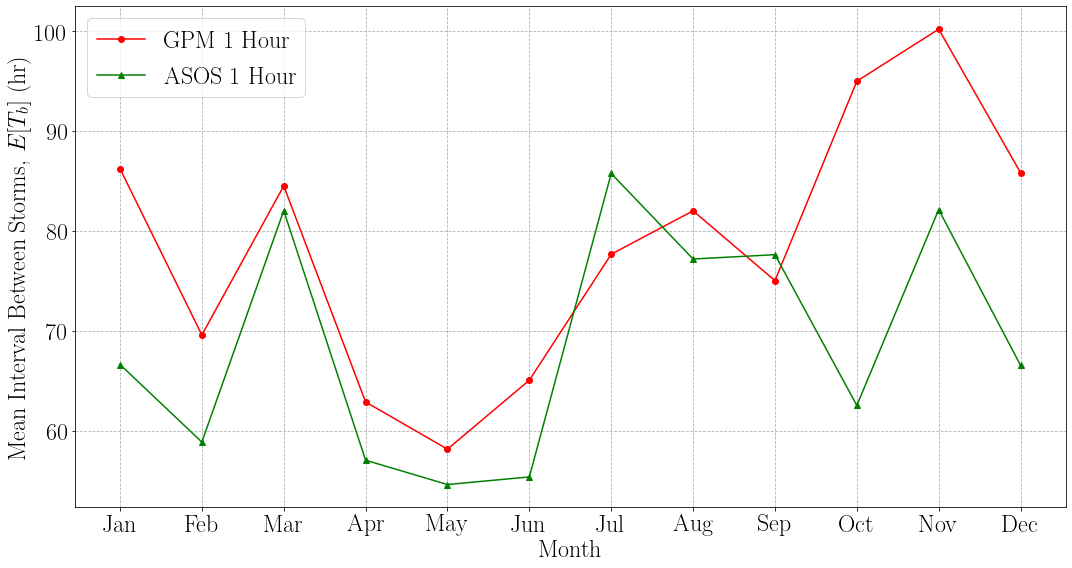

In [7]:

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(mean_tb['GPM'][:,0], mean_tb['GPM'][:,1], marker='o', color='red', label='GPM 1 Hour')
ax.plot(mean_tb['ASOS'][:,0], mean_tb['ASOS'][:,1], marker='^', color='g', label='ASOS 1 Hour')

# n, bins, patches = ax.hist(data, bins=bins, density=True, histtype='step', cumulative=-1)
ax.set_xlabel(r'Month', fontsize=24)
ax.set_ylabel(r'Mean Interval Between Storms, $E[T_{b}]$ (hr)', fontsize=24)
ax.tick_params(labelsize = 24)
ax.grid('major', linestyle='--')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# ax.set_xlim([0, 120])
# ax.set_ylim([-0.1, 1.3])
# ax.text(0.5, 0.9,r'$f_{T_b}(t_b) =' + '{:.1f}'.format(scale)+'e^{-' + '{:.1f}'.format(scale)+ 't_b} $',transform=ax.transAxes, fontsize=28)
fig.tight_layout()
ax.legend(fontsize=24)
fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/forcings/gpm_ASOS_monthly_meantb.jpg',dpi=300)


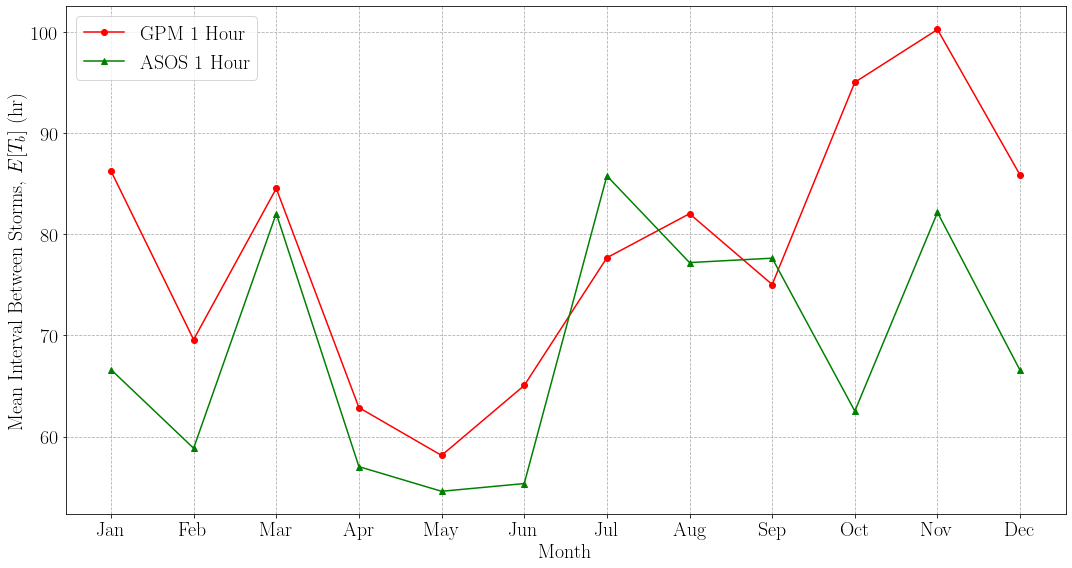

In [42]:

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(mean_tb['GPM'][:,0], mean_tb['GPM'][:,1], marker='o', color='red', label='GPM 1 Hour')
ax.plot(mean_tb['ASOS'][:,0], mean_tb['ASOS'][:,1], marker='^', color='g', label='ASOS 1 Hour')

# n, bins, patches = ax.hist(data, bins=bins, density=True, histtype='step', cumulative=-1)
ax.set_xlabel(r'Month', fontsize=20)
ax.set_ylabel(r'Mean Interval Between Storms, $E[T_{b}]$ (hr)', fontsize=20)
ax.tick_params(labelsize = 20)
ax.grid('major', linestyle='--')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# ax.set_xlim([0, 120])
# ax.set_ylim([-0.1, 1.3])
# ax.text(0.5, 0.9,r'$f_{T_b}(t_b) =' + '{:.1f}'.format(scale)+'e^{-' + '{:.1f}'.format(scale)+ 't_b} $',transform=ax.transAxes, fontsize=28)
fig.tight_layout()
ax.legend(fontsize=20)
# fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/forcings/gpm_ASOS_monthly_meantb.jpg',dpi=300)


In [127]:
events

,start,end,precip,deltat
0,2012-01-20 10:00:00,2012-01-20 22:00:00,0.663644,12.0
1,2012-01-23 00:00:00,2012-01-23 22:00:00,0.106074,22.0
2,2012-01-27 18:00:00,2012-01-28 02:00:00,0.000306,8.0
3,2012-01-29 07:00:00,2012-01-29 09:00:00,0.000612,2.0
4,2012-02-07 20:00:00,2012-02-07 22:00:00,0.000612,2.0
...,...,...,...,...
986,2020-11-24 05:00:00,2020-11-25 01:00:00,0.232872,20.0
987,2020-12-11 16:00:00,2020-12-12 17:00:00,0.196245,25.0
988,2020-12-23 16:00:00,2020-12-24 12:00:00,0.006615,20.0
989,2020-12-27 13:00:00,2020-12-28 00:00:00,0.0784,11.0


In [43]:
from functions.event_detector import storm_def
import datetime
mit_list = [x for x in range(9,11, 1)]
mit_list = [9]

mean_tb = dict()
p_events = dict()
for prod in ['GPM']:
    _prod = prod_list[prod]
    dt_col = _prod['dt_col']
    p_col = _prod['p_col']
    p_events[prod] = dict()    
    tscale = 'H'
    data = p_data[prod][tscale]
    mit_dry = []
    # events = dict()
    # dry_periods = dict()
    # storm_arrivals = dict()
    # p_events[prod][tscale] = dict()
    mit = 9
    events = storm_def(data, mit)
    dry_periods = [(events['start'][i+1] - events['end'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
    storm_arrivals = [(events['start'][i+1] - events['start'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
    mit_dry.append((mit, np.std(dry_periods)/ np.mean(dry_periods),np.std(storm_arrivals)/ np.mean(storm_arrivals), 
    np.mean(dry_periods), np.mean(storm_arrivals)))
    p_events[prod][tscale] = np.array(mit_dry)
    dry_periods = np.array(dry_periods)
    storm_arrivals = np.array(storm_arrivals)
    mean_tb[prod] = np.array([(m, np.mean(dry_periods[list(events['start'][0:-1].dt.month==m)])) for m in range(1,13)])

In [44]:
events

,start,end,precip,deltat
0,2000-06-01 02:00:00,2000-06-02 01:00:00,0.894526,23.0
1,2000-06-03 23:00:00,2000-06-04 12:00:00,0.285916,13.0
2,2000-06-10 22:00:00,2000-06-11 09:00:00,0.143526,11.0
3,2000-06-11 23:00:00,2000-06-12 07:00:00,0.07777,8.0
4,2000-06-13 07:00:00,2000-06-14 07:00:00,2.685506,24.0
...,...,...,...,...
2116,2020-12-18 15:00:00,2020-12-18 17:00:00,0.383352,2.0
2117,2020-12-20 21:00:00,2020-12-21 00:00:00,0.626884,3.0
2118,2020-12-24 03:00:00,2020-12-24 05:00:00,0.133009,2.0
2119,2020-12-27 12:00:00,2020-12-27 17:00:00,0.183199,5.0
